<a href="https://colab.research.google.com/github/khaophuthaipch/Natural_Language_Processing/blob/Initial-report/First_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team: Sagar Daswani and Pimchanok Khaoputhai**
# **EAI6000 - Foundations of AI**

# Final Project
## Initial report

#**Real or Not? Binary Classification of Disaster Tweets**
Kaggle Competition

Nowadays, social media has become a part of our daily life. People are sharing their experience and communicate to the public through platform like Facebook and Twitter. Sometimes, these channels are used for sharing emergency matters and news. However, the problem relies on whether the message is real. If yes, then monitoring these posts will help increase people awareness in time of emergency. As a result, this project is focusing on detecting if a post on Twitter about a disaster is a real event.


The flow of the project are as follows:

*   Text cleaning
    * Remove special characters
    * Stemming, Lemmatization
*   Text preprocessing
    * Transform text into proper format to use in the models :
      * Vectorization, one hot coding
      * Word Embedding
*   Modeling
    * Simple Neural Network
    * Recurrent Neural Network

Noted that for text cleaning and text preprocessing, the final model will only include the techniques that improve model accuracy. 

**Work to date**

As of March 16, 2020, we are building the structure of the project. We have built a nueral network model and we are working on improving the accuracy by exploring differetn architecture, different text representation and different cleaning method that can potentially improve the accuracy of the model. 

- Logistic Regression = 0.59
- Neural Network with vectorized feature test accuracy = 0.75
- Neural Network with embedded feature test accuracy = 0.72


In [1]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, train_test_split, cross_validate
  

## Get the Dataset from Kaggle API
*   Set up the API
*   Download data using !kaggle competitions
*   Import data






In [4]:
! pip install -q kaggle
! mkdir .kaggle

mkdir: cannot create directory ‘.kaggle’: File exists


In [5]:
import json
token = {"username":"khaophuthaipkt","key":"742f0323b5693f569538176eceaa4d80"}
with open("/content/.kaggle/kaggle.json", "w") as file:
    json.dump(token, file)

! cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
! kaggle config set -n path -v{/content}
! chmod 600 ~/.kaggle/kaggle.json

- path is now set to: {/content}


In [6]:
! kaggle competitions download -c nlp-getting-started

test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# import the data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [8]:
#Looking at first few rows of dataset
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
print("Training Dataset Size:",train_df.shape)
print("Test Dataset Size:",test_df.shape)

Training Dataset Size: (7613, 5)
Test Dataset Size: (3263, 4)


In [10]:
#missing values in training dataset
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [11]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
#exlporing location column
train_df['location'].value_counts()

USA                   104
New York               71
United States          50
London                 45
Canada                 29
                     ... 
Lebanon, Tennessee      1
DC Metro area           1
Reality                 1
Louavul, KY             1
right next to you       1
Name: location, Length: 3341, dtype: int64

##**Data Cleaning**


*   Making all uppercase to lowercase
*   Removing noise from tweets

  *   URLs
  *   HTML tags
  *   emogis
  *   Punctuation
  *   New-Line
  *   Removing Digits
*   Tokenization: Converting normal text string into a list of tokens/words
*   Stopwords removal (optional)


In [0]:
#function to remove noise from text
def clean_text(text):
    text = text.lower() #convert to lowercase to maintain standard flow between text
    text = re.sub('\[.*?\]', '', text) #removing text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) #removing url
    text = re.sub('<.*?>+', '', text) #removing html tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #removing puntuations
    text = re.sub('\n', '', text)#removing new line from the text field
    text = re.sub('\w*\d\w*', '', text) #removing digits from the string
    return text

train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

In [0]:
#function to remove emoji's
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df['text']=train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text']=test_df['text'].apply(lambda x: remove_emoji(x))

In [0]:
#adding new column with the count of words in a single row
train_df['word_count'] = train_df['text'].str.split().map(len)

#only using the rows with word count more than 0
train_df = train_df[train_df['word_count'] > 0]

#moving forward with 2 column from dataset , i.e., text and target
train_df = train_df[["text","target"]]
test_df = test_df[["text"]]

In [16]:
train_df

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,ariaahrary thetawniest the out of control wild...,1
7610,s of volcano hawaii,1
7611,police investigating after an ebike collided w...,1


### Stemming

This part is still a work in progress

In [0]:
snowball = nltk.stem.SnowballStemmer(language='english')
def text_stemming(text):
  tokenizer = nltk.tokenize.TreebankWordTokenizer()
  text_token = tokenizer.tokenize(text)
  stem_word = [snowball.stem(x) for x in text_token]
  return stem_word

In [0]:
train_df['stemmed'] = train_df['text'].apply(text_stemming)
train_df['stemmed'] = [" ".join(word) for word in train_df['stemmed']]

## **Data Preprocessing**

*   One Hot coding
*   Word Embedding



### Vectorized

In [0]:
# Split train dataset for cross validation and create token
training_sentences = [ i for i in train_df.text[:6000]]
test_sentences = [i for i in train_df.text[6000:]]
                  
training_labels = [ i for i in train_df.target[:6000]]
test_labels = [i for i in train_df.target[6000:]]

tokenizer = Tokenizer(num_words=10000,oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [0]:
# Encode sentences 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Padding
training_padded = pad_sequences(training_sequences,padding='post')
test_padded = pad_sequences(test_sequences,padding='post')

In [21]:
# From index to sentence
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i, '?') for i in training_sequences[0]]))

Original review:  our deeds are the reason of this earthquake may allah forgive us all


In [0]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

In [0]:
x_train = vectorize_sequences(training_sequences, dimension=len(word_index))
x_test = vectorize_sequences(test_sequences, dimension=len(word_index))
y_train = np.asarray(training_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## **Linear Model**


In [24]:
logreg = LogisticRegression()
logreg_scores = cross_validate(logreg, x_train, y_train, cv=5, scoring="f1", n_jobs=-1, return_train_score=True)
logreg_scores

{'fit_time': array([15.966501  , 17.60741234, 16.18627   , 14.95000291,  9.0760448 ]),
 'score_time': array([0.05304193, 0.06006598, 0.05713105, 0.0538795 , 0.02613282]),
 'test_score': array([0.63461538, 0.52548131, 0.57266811, 0.6       , 0.63255814]),
 'train_score': array([0.93604951, 0.93555841, 0.93666323, 0.94374518, 0.93978991])}

In [25]:
logreg_scores['test_score'].mean()

0.5930645901303635

## **Building the Neural Network**

### Vectorized feature

In [0]:
model_vec = tf.keras.Sequential()
model_vec.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(len(word_index),)))
model_vec.add(tf.keras.layers.Dense(16, activation='relu'))
model_vec.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_vec.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
history_vec = model_vec.fit(x_train, y_train,
                    epochs=20, batch_size=512, verbose=2,
                    validation_data=(x_test, y_test))

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 - 1s - loss: 0.6668 - accuracy: 0.6063 - val_loss: 0.6530 - val_accuracy: 0.5713
Epoch 2/20
6000/6000 - 1s - loss: 0.5968 - accuracy: 0.7528 - val_loss: 0.6156 - val_accuracy: 0.7053
Epoch 3/20
6000/6000 - 1s - loss: 0.5348 - accuracy: 0.8172 - val_loss: 0.5873 - val_accuracy: 0.7506
Epoch 4/20
6000/6000 - 1s - loss: 0.4803 - accuracy: 0.8500 - val_loss: 0.5634 - val_accuracy: 0.7655
Epoch 5/20
6000/6000 - 1s - loss: 0.4302 - accuracy: 0.8683 - val_loss: 0.5414 - val_accuracy: 0.7885
Epoch 6/20
6000/6000 - 1s - loss: 0.3847 - accuracy: 0.8877 - val_loss: 0.5253 - val_accuracy: 0.7878
Epoch 7/20
6000/6000 - 1s - loss: 0.3425 - accuracy: 0.9017 - val_loss: 0.5145 - val_accuracy: 0.7872
Epoch 8/20
6000/6000 - 1s - loss: 0.3060 - accuracy: 0.9102 - val_loss: 0.5032 - val_accuracy: 0.7823
Epoch 9/20
6000/6000 - 1s - loss: 0.2741 - accuracy: 0.9168 - val_loss: 0.4996 - val_accuracy: 0.7748
Epoch 10/20
6000/6000 - 1s - loss:

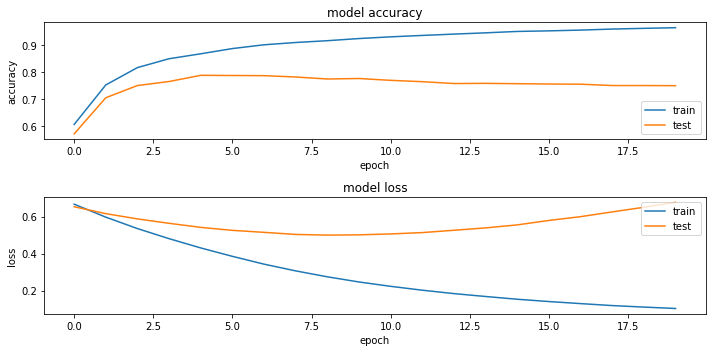

In [28]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(history_vec.history['accuracy'])
plt.plot(history_vec.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_vec.history['loss'])
plt.plot(history_vec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [29]:
print('\n# Evaluate on test data')
results = model_vec.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
1612/1612 [==============================] - 0s 74us/sample - loss: 0.6770 - accuracy: 0.7500
test loss, test acc: [0.6769819213054317, 0.75]


### **Word Embedding** 
Tensorflow model


In [0]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

test_padded = np.array(test_padded)
test_labels = np.array(test_labels)

In [0]:
model_embed = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index), 32),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_embed.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [32]:
model_embed.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          458080    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 459,681
Trainable params: 459,681
Non-trainable params: 0
_________________________________________________________________


In [33]:
num_epochs = 20
history_embed = model_embed.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), verbose=2)

Train on 6000 samples, validate on 1612 samples
Epoch 1/20
6000/6000 - 1s - loss: 0.6543 - accuracy: 0.6020 - val_loss: 0.6363 - val_accuracy: 0.5974
Epoch 2/20
6000/6000 - 1s - loss: 0.5038 - accuracy: 0.7890 - val_loss: 0.5156 - val_accuracy: 0.7736
Epoch 3/20
6000/6000 - 1s - loss: 0.4024 - accuracy: 0.8325 - val_loss: 0.4833 - val_accuracy: 0.7816
Epoch 4/20
6000/6000 - 1s - loss: 0.3547 - accuracy: 0.8560 - val_loss: 0.4790 - val_accuracy: 0.7816
Epoch 5/20
6000/6000 - 1s - loss: 0.3256 - accuracy: 0.8650 - val_loss: 0.4867 - val_accuracy: 0.7804
Epoch 6/20
6000/6000 - 1s - loss: 0.3066 - accuracy: 0.8780 - val_loss: 0.4806 - val_accuracy: 0.7723
Epoch 7/20
6000/6000 - 1s - loss: 0.2915 - accuracy: 0.8863 - val_loss: 0.4882 - val_accuracy: 0.7705
Epoch 8/20
6000/6000 - 1s - loss: 0.2781 - accuracy: 0.8907 - val_loss: 0.4974 - val_accuracy: 0.7674
Epoch 9/20
6000/6000 - 1s - loss: 0.2684 - accuracy: 0.8952 - val_loss: 0.5043 - val_accuracy: 0.7748
Epoch 10/20
6000/6000 - 1s - loss:

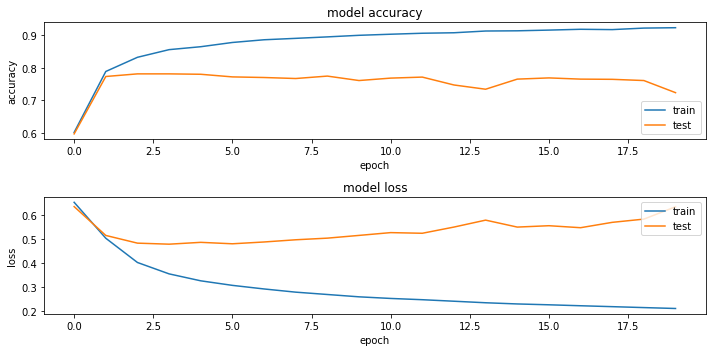

In [34]:
fig = plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(history_embed.history['accuracy'])
plt.plot(history_embed.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_embed.history['loss'])
plt.plot(history_embed.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [35]:
print('\n# Evaluate on test data')
results = model_embed.evaluate(test_padded, test_labels, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
1612/1612 [==============================] - 0s 16us/sample - loss: 0.6356 - accuracy: 0.7239
test loss, test acc: [0.6356350357272194, 0.72394544]


#### Retrieve the learned embeddings

In [37]:
e = model_embed.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(14315, 32)


## RNN
This part is still a work in progress. Refering to RNN from tensorflow documentation

# References

* Exploration : https://www.kaggle.com/aaroha33/
disaster-tweets-evaluation-with-nlp
* RNN : https://www.tensorflow.org/tutorials/text/text_classification_rnn